# General Assembly London, Data Science - Final Project
## Final Project Written Report

- **Name:** Robert Dabin
- **Domain:** Digital Advertising Auctions
- **Company:** OnScroll

### The problem.
OnScroll works with publishers to sell their online advertising placements and generate revenues for them. To do this We use AppNexus, a digital advertising exchange, to sell Inventory to advertisers. To keep our publishers happy We want to sell the inventory for the maximum price bidders are willing to pay for it. Specifically we want to investigate in to improving yield on the publisher Autotrader's inventory.

To do this it is important to find out what features are important to winning bids (in auctions) which could possibly be used to increase yield. For example campaigns for specific brands may spend higher on Autotrader inventory and we could use soft and hard floors to increase yield from auctions where these campaigns participate.

### My Hypothesis.
Features of bidders such as creative_id, brand_id and buyer_id will strong indicators of winning bids and therefor be important features in my model(s).

### Business impact of my findings.
I expect to increase revenue generated by publisher inventory by more accurately finding the best level to set bidding floors to ensure inventory is sold closer to the maximum advertisers are willing to pay for it.

There will also be valuable insights in to how bidders behave, who buys with us and what approaches they take and what is sought after inventory and what is not. also how a more analytical scientific approach can be used to make (better) use of company data in general.


### Exploratory Data Analysis

Firstly below are imports of the libraries I have used for both exploratory data analysis, modelling and model analysis.

The data set of bids on auctions is from AppNexus' "Bid Landscape Feed" which is accessible in hourly chunks in csv format. For this analysis I am looking at a csv containing data from the Sunday 24/04/2016 from 12pm to 1pm. Each row in the dataset is an individual bid and includes an auction ID which can br grouped on.

The columns of the csv are as follows:
- date_time: The date and time of the bid.

- auction_id_64: The ID of the AppNexus auction that included the bid.

- user_id_64: The ID of the user associated with the bid.

- brand_id: The ID of the brand for the creative that was bid.

- creative_id: The ID of the creative that was bid.

- actual_bid_price: The actual price of the bid, net of AppNexus fees.

- biased_bid_price: The biased price of the bid, if yield management biases were applied to the buyer.

- bid_reject_reason: The reason that the bid was rejected. See Bid Reject Codes below.

- ym_floor_id: The ID of the yield management floor that was applied to the buyer, if any.

- ym_bias_id: The ID of the yield management bias that was applied to the buyer, if any.

- bidder_id: The ID of the bidder.

- buyer_member_id: The ID of the buying member.

- seller_member_id: The ID of the selling member.

- total_bid_modifier: The total amount added to or deducted from the bid due to yield management biases and/or modifiers, if any.

- exclusivity_level: When the impbus determines the winning bid for the auction, bids with higher values get precedence over bids with lower values. Sellers can use this information to run auction simulations.

  Allowed values:
  - 0 = Learn bid on a non-prefer learn impression or give up bid
  - 1 = Non exclusive
  - 2 = Exclusive
  - 3 = Learn bid on a prefer-learn impression


- ym_auction_tier_id: If applicable, the ID of the Yield Management Auction Tier into which this bid was categorized. Tiers have a priority, and bids in tiers of higher priority get preference over bids in tiers of lower priority. Sellers can use this information to run auction simulations. For more information, see the Yield Management Auction Tier Service.

- hard_floor: The hard floor specified in the seller's Yield Management Profile. Defaults to 0 if there was no hard floor on the Yield Management profile.

- modified_hard_floor: The floor actually applied in the auction. This can differ from the value of hard_floor due to floor optimization and floor modifiers. Defaults to 0 if there was no hard floor applied in the auction.

- soft_floor: The soft floor specified in the seller's Yield Management Profile. Defaults to 0 if there was no soft floor on the Yield Management profile.

- modified_soft_floor: The soft floor that is actually supplied in the auction. This can differ from the value in soft_floor due to floor optimization and floor modifiers. Defaults to 0 if there was no soft floor applied in the auction.

- bid_payment_type: How the buyer was to have paid for the impression:
  - 0 = CPM
  - 1 = CPC or CPA
  - Defaults to 0.
- is_winning_bid: Whether this bid won the impression:
  - 0 = no
  - 1 = yes


- deal_id: The ID of the deal that was used to coordinate this bid on your inventory. Defaults to 0 if no deal was used.

- ad_profile_id: The publisher-level ad profile ID that was applied to this impression. This is used during bid rejection analysis to let the seller know which ad profile allowed or blocked the creative. Defaults to 0 if no publisher-level ad profile was used. Note that this value will never be the global ad profile.

- is_mediated_bid: Whether this bid is coming from mediated demand:
  - 0 = standard
  - 1 = mediation
  
  
I also required another dataset (AppNexus' "Standard Feed"). This was to identify what auction Ids corresponded to Autotrader auctions as this information was not avaliable in the "Bid Lanscape Feed". Below I read both CSVs in to Pandas dataFrames for my exploratory analysis.
 
As we are trying to predict winning bids the column IS_WINNING_BID is chosen to be our target variable.

In [1043]:
import pandas as pd
import numpy as np
from sklearn import neighbors, linear_model, ensemble, metrics, cross_validation, grid_search
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
%matplotlib inline

# load in the data to build model on (date: 2016/04/24, hour: 12 noon)

# bid landscape feed column names
bid_ls_col_names = ["AUCTION_ID_64","USER_ID_64","BRAND_ID","CREATIVE_ID","ACTUAL_BID_PRICE","BIASED_BID_PRICE","BID_REJECT_REASON","YM_FLOOR_ID","YM_BIAS_ID","BIDDER_ID","BUYER_MEMBER_ID","SELLER_MEMBER_ID","TOTAL_BID_MODIFIER","EXCLUSIVITY_LEVEL","YM_AUCTION_TIER_ID","HARD_FLOOR","MODIFIED_HARD_FLOOR","SOFT_FLOOR","MODIFIED_SOFT_FLOOR","BID_PAYMENT_TYPE","IS_WINNING_BID","DEAL_ID","AD_PROFILE_ID","IS_MEDIATED_BID"]

# bid landscape feed - primary data source
bls_04_24_12 = pd.read_csv('./data/bid_ls_data_2016_04_24_12.tsv', delimiter='\t', header=None, index_col=0)
# set column/feature names
bls_04_24_12.columns = bid_ls_col_names

# standard feed (possible supplimentary data/features and how to pick out autotrader specific auction_ids)
std_04_24_12 = pd.read_csv('./data/std_feed_data_2016_04_24_12.tsv', delimiter='\t', header=None)

# load in data to test model generalises (date: 2016/05/01, hour: 12 noon)

# bid landscape feed - primary data source
bls_05_01_12 = pd.read_csv('./data/bid_ls_data_2016_05_01_12.tsv', delimiter='\t', header=None, index_col=0)
# set column/feature names
bls_05_01_12.columns = bid_ls_col_names

# standard feed (possible supplimentary data/features and how to pick out autotrader specific auction_ids)
std_05_01_12 = pd.read_csv('./data/std_feed_data_2016_05_01_12.tsv', delimiter='\t', header=None)

In [1044]:
# for modelling data look at specific auction to see what a
print bls_04_24_12[bls_04_24_12['AUCTION_ID_64'] == 8827786699033177918][['ACTUAL_BID_PRICE','IS_WINNING_BID','BID_REJECT_REASON']].sort_values(by=['ACTUAL_BID_PRICE'])
print ""
# how many rows in total primary and supplimentary dataset?
print "bls feed row count: ", len(bls_04_24_12)
print "std feed row count: ", len(std_04_24_12)

                     ACTUAL_BID_PRICE  IS_WINNING_BID  BID_REJECT_REASON
0                                                                       
2016-04-24 12:59:14          0.002939               0                304
2016-04-24 12:59:14          0.056183               0                307
2016-04-24 12:59:14          0.067230               0                304
2016-04-24 12:59:14          0.072555               0                401
2016-04-24 12:59:14          0.078136               0                401
2016-04-24 12:59:14          0.118113               0                401
2016-04-24 12:59:14          0.232470               0                401
2016-04-24 12:59:14          0.387990               0                304
2016-04-24 12:59:14          0.456000               0                  0
2016-04-24 12:59:14          0.481950               0                  0
2016-04-24 12:59:14          0.547314               0                  0
2016-04-24 12:59:14          0.589167              

Below: finding auctions on Autotrader inventory in the "Standard Feed" and using these Ids to filter to only Autotrader auctions in the "Bid Landscape Feed". 


In [1045]:
# select rows where the domain on which the ad placement is auctioned equals 'autotrader.co.uk'.
# Inspect auction id and domain
print std_04_24_12[[0,31]].iloc[0:3]
print ""
print std_04_24_12[std_04_24_12[31] == 'autotrader.co.uk'][[0,31]].iloc[0:3]
print ""
print "std feed autotrader auction row count: ", len(std_04_24_12[std_04_24_12[31] == 'autotrader.co.uk'])


                    0                 31
0  8782808157621532877     techradar.com
1  8120404432469033821       squawka.com
2  8700981905811600820  goodtoknow.co.uk

                     0                 31
3   8906521755579031004  autotrader.co.uk
9   8647074755339378238  autotrader.co.uk
19  8676583160420064932  autotrader.co.uk

std feed autotrader auction row count:  116952


In [1046]:
# build array of autotrader_auction_ids from standard feed domain column [31] and auction_id_64 [0]
autotrader_auction_ids = [ id for id in std_04_24_12[std_04_24_12[31] == 'autotrader.co.uk'][0]]
# check filtered bids
print len(autotrader_auction_ids)
print ""
print autotrader_auction_ids[5]
print ""
print std_04_24_12[std_04_24_12[0] == autotrader_auction_ids[5]][31]

116952

8771623414418749222

30    autotrader.co.uk
Name: 31, dtype: object


Once we have filtered our "Bid Landscape Feed" data (24/04/2016 12pm to 1pm) to only include Autorader auctions we can look at the bias in our data. Looking at both the filtered (Autotrader) and unfiltered data we can see that only ~9% of bids on Autotrader auctions are winning compared to ~12% on all auctions. This shows us that there are a larger proportion of losing bids on Autotrader Inventory compared to the dataset as a whole meaning on average more bidders per auction on Autotrader Inventory compared to auctions as a whole.

In [1047]:
# filter bid feed data to only contain autotrader auctions
autotrader_bls_04_24_12 = bls_04_24_12[bls_04_24_12['AUCTION_ID_64'].isin(autotrader_auction_ids)]
print "bls feed row count: ", len(bls_04_24_12)
print "(autotrader auctions only) bls feed row count: ", len(autotrader_bls_04_24_12)
print "prior probability/bias (all bls bids winning bid %): {:f}%".format(bls_04_24_12['IS_WINNING_BID'].mean() * 100)
print "prior probability/bias (autotrader bids winning bid %): {:f}%".format(autotrader_bls_04_24_12['IS_WINNING_BID'].mean() * 100)

bls feed row count:  23706
(autotrader auctions only) bls feed row count:  7186
prior probability/bias (all bls bids winning bid %): 12.558002%
prior probability/bias (autotrader bids winning bid %): 9.337601%


Out of the 24 columns in our dataset there are 21 possible features:

"USER_ID_64","BRAND_ID","CREATIVE_ID","ACTUAL_BID_PRICE","BIASED_BID_PRICE","BID_REJECT_REASON",
"YM_FLOOR_ID","YM_BIAS_ID","BUYER_MEMBER_ID","SELLER_MEMBER_ID","TOTAL_BID_MODIFIER","EXCLUSIVITY_LEVEL",
"YM_AUCTION_TIER_ID","HARD_FLOOR","MODIFIED_HARD_FLOOR","SOFT_FLOOR","MODIFIED_SOFT_FLOOR","BID_PAYMENT_TYPE",
"DEAL_ID","AD_PROFILE_ID","IS_MEDIATED_BID"

Of these 21, 7 are continuous
("ACTUAL_BID_PRICE","BIASED_BID_PRICE","TOTAL_BID_MODIFIER","HARD_FLOOR",
"MODIFIED_HARD_FLOOR","SOFT_FLOOR","MODIFIED_SOFT_FLOOR"). "TOTAL_BID_MODIFIER" is always 0 and so will be of no use in our modelling. The remaining 14 are Ids and as such are categorical.

Since "AUCTION_ID_64" is unique per auction this will be of no use in building our model. Also "BIDDER_ID" is the Id of the hardware/software that the auction is run on. This should not impact the outcome of an auction.

our target variable is "IS_WINNING_BID".

In [1048]:
autotrader_bls_04_24_12.columns

Index([u'AUCTION_ID_64', u'USER_ID_64', u'BRAND_ID', u'CREATIVE_ID',
       u'ACTUAL_BID_PRICE', u'BIASED_BID_PRICE', u'BID_REJECT_REASON',
       u'YM_FLOOR_ID', u'YM_BIAS_ID', u'BIDDER_ID', u'BUYER_MEMBER_ID',
       u'SELLER_MEMBER_ID', u'TOTAL_BID_MODIFIER', u'EXCLUSIVITY_LEVEL',
       u'YM_AUCTION_TIER_ID', u'HARD_FLOOR', u'MODIFIED_HARD_FLOOR',
       u'SOFT_FLOOR', u'MODIFIED_SOFT_FLOOR', u'BID_PAYMENT_TYPE',
       u'IS_WINNING_BID', u'DEAL_ID', u'AD_PROFILE_ID', u'IS_MEDIATED_BID'],
      dtype='object')

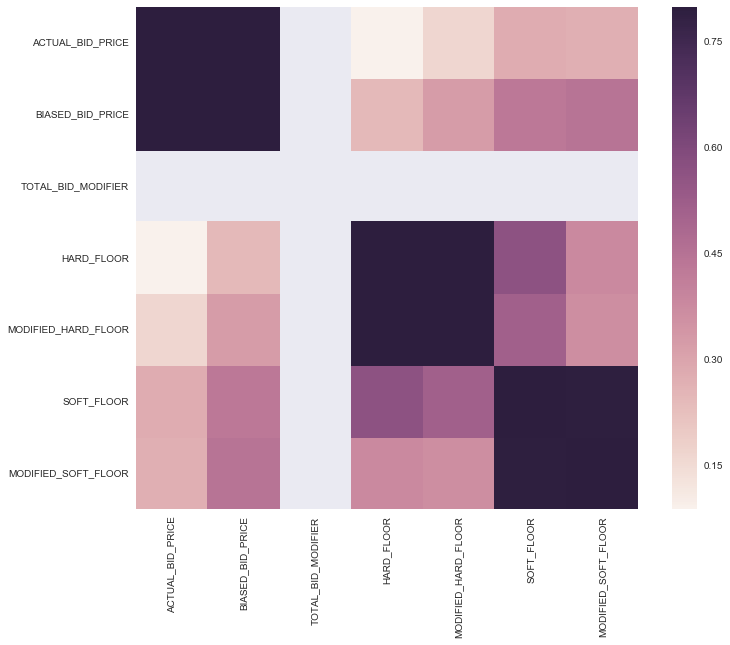

In [1049]:
corr = autotrader_bls_04_24_12[
    ["ACTUAL_BID_PRICE","BIASED_BID_PRICE",
     "TOTAL_BID_MODIFIER","HARD_FLOOR", "MODIFIED_HARD_FLOOR","SOFT_FLOOR","MODIFIED_SOFT_FLOOR"]].corr()
f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corr, vmax=.8, square=True)

Looking at the continuous variables correlation matrix heatmap we can see that possibly colinear pairs are ACTUAL_BID_PRICE and BIASED_BID_PRICE, HARD_FLOOR and MODIFIED_HARD_FLOOR, and SOFT_FLOOR and MODIFIED_SOFT_FLOOR. based on this we are likely to build a better model (if using a logistic regression) from picking one feature from each of these pairs so to avoid colinearity as this would make it difficult to discern which features are important to our model.

In [1050]:
# show basic descriptive statistics for relevant columns
autotrader_bls_04_24_12[['ACTUAL_BID_PRICE', 'HARD_FLOOR', 'SOFT_FLOOR', 'IS_WINNING_BID']].describe()

,ACTUAL_BID_PRICE,HARD_FLOOR,SOFT_FLOOR,IS_WINNING_BID
count,7186.000000,7186.000000,7186.000000,7186.000000
mean,0.381912,0.130615,0.679910,0.093376
std,0.805642,0.159055,1.020415,0.290979
min,0.000000,0.000000,0.000000,0.000000
25%,0.058587,0.000000,0.000000,0.000000
50%,0.193156,0.240000,0.610000,0.000000
75%,0.437851,0.240000,0.850000,0.000000
max,17.000000,2.500000,15.960000,1.000000


Looking at the descriptive statistics for ACTUAL_BID_PRICE, HARD_FLOOR and SOFT_FLOOR there appears to be some outliers in the data. As we can see especially w/ ACTUAL_BID_PRICE and HARD_FLOOR the mean's and quartiles are all < 1 but we have maximum values of 17.00 and 15.96 repectively.

Looking at the distribution of ACTUAL_BID_Price below, we can see a "long tail" of outliers. 

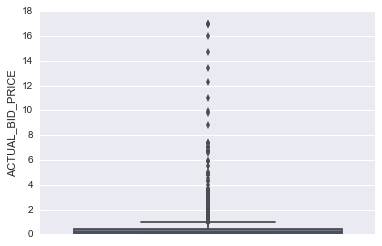

In [1051]:
# boxplot of actual bid price - show higly skewed data w/ some extreme outliers
# [((17-0.38)/0.806) std devs away from mean] 
sns.boxplot(y=autotrader_bls_04_24_12['ACTUAL_BID_PRICE'])

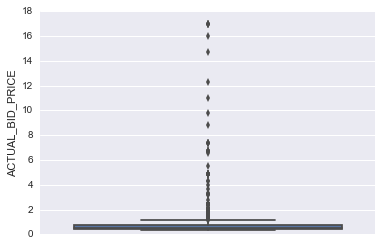

In [1052]:
# removing rejected bids
sns.boxplot(y=autotrader_bls_04_24_12[autotrader_bls_04_24_12['BID_REJECT_REASON'] == 0]['ACTUAL_BID_PRICE'])

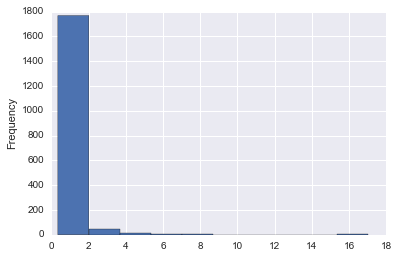

In [1053]:
autotrader_bls_04_24_12[autotrader_bls_04_24_12['BID_REJECT_REASON'] == 0]['ACTUAL_BID_PRICE'].plot(kind='hist')

In [1054]:
at_act_bid_price = autotrader_bls_04_24_12[autotrader_bls_04_24_12['BID_REJECT_REASON'] == 0]['ACTUAL_BID_PRICE']
autot_valid_bids = autotrader_bls_04_24_12[autotrader_bls_04_24_12['BID_REJECT_REASON'] == 0]

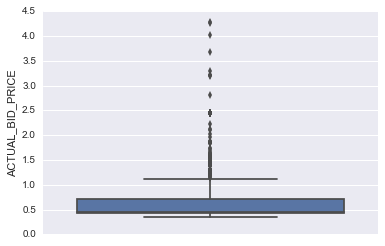

In [1055]:
# remove outliers -> bid price > 3 std devs away from the mean
not_outliers = np.abs(autot_valid_bids['ACTUAL_BID_PRICE'] - autot_valid_bids['ACTUAL_BID_PRICE'].mean())<=(3*autot_valid_bids['ACTUAL_BID_PRICE'].std())
rmd_outliers = autot_valid_bids[not_outliers]

sns.boxplot(y=rmd_outliers['ACTUAL_BID_PRICE'])

Once we have removed invalid bids, outliers (data > 3 std devs from mean), we can see the distribution of the main part of the data. From the box plot we can see a the data is possibly positively skewed. Looking at a histogram this appears to be the case. It also looks like a highly positive kurtosis. Looking at the shape this could possibly be modelled by an exponential distribution. 

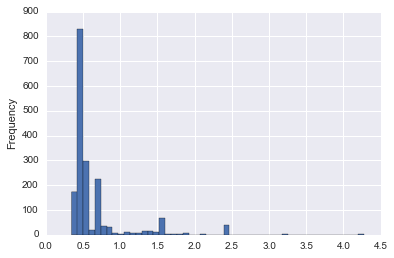

In [1056]:
rmd_outliers['ACTUAL_BID_PRICE'].plot(kind='hist', bins=50)

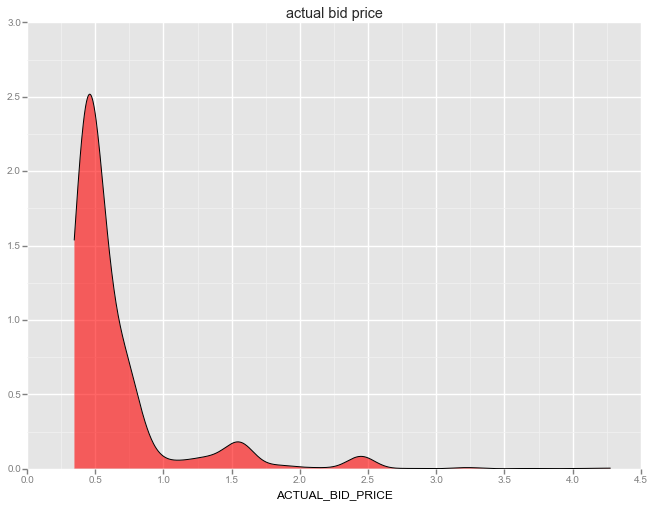

<ggplot: (385140609)>

In [1057]:
# density plot
ggplot(aes(x='ACTUAL_BID_PRICE'), data=rmd_outliers) + geom_density(alpha=0.6, colour='black', fill='red') + ggtitle('actual bid price')

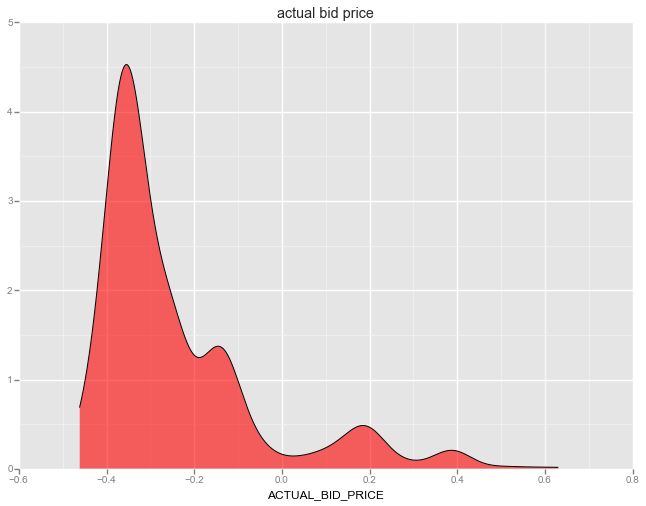

<ggplot: (385041481)>

In [1058]:
# transform
transfromed_rmd_outliers = rmd_outliers.copy()
transfromed_rmd_outliers['ACTUAL_BID_PRICE'] = transfromed_rmd_outliers['ACTUAL_BID_PRICE'].apply(np.log10)
ggplot(aes(x='ACTUAL_BID_PRICE'), data=transfromed_rmd_outliers) + geom_density(alpha=0.6, colour='black', fill='red') + ggtitle('actual bid price')
#ggplot(aes(x='ACTUAL_BID_PRICE', y=''), data=transfromed_rmd_outliers) + geom_point() + stat_smooth(method='lm', colour='blue')


Looking at the density plots above of ACTUAL_BID_PRICE, we can this column may have more than a singular mode. For example a specific group of users being targeted with higher bids, therefore we could look in to finding out how to classify these users and model these modes separately.

Also we can see that applying a simple logarithmic transformation to the data does not seem to make it any more normally distributed so we may have to look in to other kinds of transformations.

In [1059]:
# look at brands that have bid > $10 in total in the hour and see total bid value
# from this see important/valuable brands
autot_valid_bids[['ACTUAL_BID_PRICE', 'BRAND_ID']].groupby(['BRAND_ID']).filter(lambda x: x['ACTUAL_BID_PRICE'].sum() > 10).groupby(['BRAND_ID']).sum()

,ACTUAL_BID_PRICE
BRAND_ID,
1,197.897220
39,41.623470
68,14.691056
117,12.969812
1040,20.951261
1148,11.998713
2334,128.256856
3506,137.530978
4412,91.867352


In [1060]:
# see smaller brands - less $ to spend
autot_valid_bids[['ACTUAL_BID_PRICE', 'BRAND_ID']].groupby(['BRAND_ID']).filter(lambda x: x['ACTUAL_BID_PRICE'].sum() < 5 and x['ACTUAL_BID_PRICE'].sum() > 1.5).groupby(['BRAND_ID']).sum()

,ACTUAL_BID_PRICE
BRAND_ID,
173,3.019090
681,2.800000
2438,2.430000
5849,2.651445
7077,1.820133
8563,2.277115
13329,1.562726
16101,4.253949
19306,2.852501


In [1061]:
# look at winning/losing bid counts
autot_valid_bids[['IS_WINNING_BID', 'AUCTION_ID_64']].groupby(['IS_WINNING_BID']).count()

,AUCTION_ID_64
IS_WINNING_BID,
0,1180
1,671


## Modelling

### kNN

In [1062]:
# fit knn model & check score (accuracy)

X = autot_valid_bids[['BRAND_ID', 'CREATIVE_ID', 'ACTUAL_BID_PRICE','BIASED_BID_PRICE','BIDDER_ID','BUYER_MEMBER_ID','EXCLUSIVITY_LEVEL','HARD_FLOOR','SOFT_FLOOR']]
y = autot_valid_bids.IS_WINNING_BID

knn = neighbors.KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X, y)
knn.predict(X)
print "score: {:f} (% of correct predictions made against all predictions)".format(knn.score(X, y) * 100)

score: 72.447326 (% of correct predictions made against all predictions)


In [1063]:
# fit knn model & check score (accuracy)

X_reduced_features = autot_valid_bids[['ACTUAL_BID_PRICE','SOFT_FLOOR']]
y = autot_valid_bids.IS_WINNING_BID

knn = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_reduced_features, y)
knn.predict(X_reduced_features)
print "score: {:f} (% of correct predictions made against all predictions)".format(knn.score(X_reduced_features, y) * 100)

score: 77.093463 (% of correct predictions made against all predictions)


In [1064]:
# try w/ different weight param
knn = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(X_reduced_features, y)
knn.predict(X_reduced_features)
print "score: ", knn.score(X_reduced_features, y)

score:  0.77093462993


In [1065]:
# now w/ cross validation & grid search weights uniform
np.random.seed(1)

kf = cross_validation.KFold(len(X_reduced_features), n_folds = 5, shuffle=True)

try_neighbours = range(1,100)

gs = grid_search.GridSearchCV(
    estimator=neighbors.KNeighborsClassifier(),
    param_grid={
        'n_neighbors': try_neighbours,
        'weights': ['uniform']
    },
    cv=kf)

gs.fit(X_reduced_features, y)

print "best estimator/score: "
print ""
print gs.best_estimator_
print ""
print gs.best_score_

best estimator/score: 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=50, p=2,
           weights='uniform')

0.724473257699


In [1066]:
# now w/ cross validation & grid search weights distance 
np.random.seed(1)

kf = cross_validation.KFold(len(X_reduced_features), n_folds = 5, shuffle=True)

try_neighbours = range(1,100)

gs = grid_search.GridSearchCV(
    estimator=neighbors.KNeighborsClassifier(),
    param_grid={
        'n_neighbors': try_neighbours,
        'weights': ['distance']
    },
    cv=kf)

gs.fit(X_reduced_features, y)

print "best estimator/score: "
print ""
print gs.best_estimator_
print ""
print gs.best_score_

best estimator/score: 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='distance')

0.72717450027


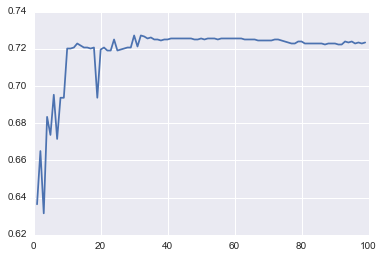

In [1067]:
plt.plot(try_neighbours, [s[1] for s in  gs.grid_scores_])

best estimator/score: 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='distance')

0.72717450027


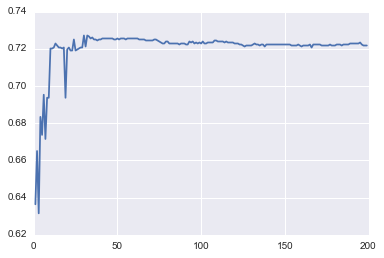

In [1068]:
try_neighbours = range(1,200)

gs = grid_search.GridSearchCV(
    estimator=neighbors.KNeighborsClassifier(),
    param_grid={
        'n_neighbors': try_neighbours,
        'weights': ['distance']
    },
    cv=kf)

gs.fit(X_reduced_features, y)

print "best estimator/score: "
print ""
print gs.best_estimator_
print ""
print gs.best_score_

plt.plot(try_neighbours, [s[1] for s in  gs.grid_scores_])

### Benchmarks of naive models

In [1069]:
print "CONFUSION MATRIX: (predict all bids winning)"
print ""
print "       DID BID WIN?"
print "       YES\tNo"
print "P"
print "R YES  {:d}\t{:d} ".format(671, 1851-671)
print "E"
print "D No   {:d}\t{:d} ".format(0, 0)

CONFUSION MATRIX: (predict all bids winning)

       DID BID WIN?
       YES	No
P
R YES  671	1180 
E
D No   0	0 


In [1070]:
print "tpr: {:f}%".format(671.0 * 100 / (671 + 0))
print "fpr: {:f}%".format(1180.0 * 100 / (1180 + 0))
print "precision: {:f}%".format(671.0 * 100 / (671 + 1180))

print "accuracy/score: {:f}%".format(671.0 * 100/(1180+671))

tpr: 100.000000%
fpr: 100.000000%
precision: 36.250675%
accuracy/score: 36.250675%


In [1071]:
print "CONFUSION MATRIX: (predict all bids losing)"
print ""
print "       DID BID WIN?"
print "       YES\tNo"
print "P"
print "R YES  {:d}\t{:d} ".format(0, 0)
print "E"
print "D No   {:d}\t{:d} ".format(671, 1851-671)

CONFUSION MATRIX: (predict all bids losing)

       DID BID WIN?
       YES	No
P
R YES  0	0 
E
D No   671	1180 


In [1072]:
print "tpr: {:f}%".format(0.0 * 100 / (0 + 671))
print "fpr: {:f}%".format(0.0 * 100 / (1180 + 0))
print "precision: {:f}%".format(0.0 * 100 / (0 + 0.000001))

print "accuracy/score: {:f}%".format(1180.0 * 100/(1180+671))

tpr: 0.000000%
fpr: 0.000000%
precision: 0.000000%
accuracy/score: 63.749325%


### kNN Candidate model

In [1073]:
#candidate_model_knn = neighbors.KNeighborsClassifier(
#    algorithm='auto',
#    leaf_size=30,
#    metric='minkowski',
#    metric_params=None,
#    n_jobs=1,
#    n_neighbors=4,
#    p=2,
#    weights='uniform')
candidate_model_knn = grid_search.GridSearchCV(
    estimator=neighbors.KNeighborsClassifier(),
    param_grid={
        'n_neighbors': try_neighbours,
        'weights': ['distance']
    },
    cv=kf)

candidate_model_knn.fit(X_reduced_features, y)


print "total:", len(y)
print "actual # yes:", sum(y)
print "actual # no:", len(y) - sum(y)
print "predicted # yes:", sum(candidate_model_knn.predict(X_reduced_features))
print "predicted # no:", len(candidate_model_knn.predict(X_reduced_features)) - sum(candidate_model_knn.predict(X_reduced_features))

print "tn", len([ 1 for predicted, actual in zip(candidate_model_knn.predict(X_reduced_features), y) if predicted == 0 and actual == 0])
print "tp", len([ 1 for predicted, actual in zip(candidate_model_knn.predict(X_reduced_features), y) if predicted == 1 and actual == 1])
print 

total: 1851
actual # yes: 671
actual # no: 1180
predicted # yes: 356
predicted # no: 1495
tn 1126
tp 302



### kNN Candidate Scoring

In [1074]:
print "CONFUSION MATRIX: (kNN)"
print ""
print "       DID BID WIN?"
print "       YES\tNo"
print "P"
print "R YES  {:d}\t{:d} ".format(302, 356-302)
print "E"
print "D No   {:d}\t{:d} ".format(1495-1126, 1126)

print ""
print "things to note: low # false positives, fairly high # false negatives"
print ""
print "check..", metrics.confusion_matrix(y, candidate_model_knn.predict(X_reduced_features))

CONFUSION MATRIX: (kNN)

       DID BID WIN?
       YES	No
P
R YES  302	54 
E
D No   369	1126 

things to note: low # false positives, fairly high # false negatives

check.. [[1126   54]
 [ 369  302]]


In [1075]:
knn_candidate_score = metrics.precision_score(y, candidate_model_knn.predict(X_reduced_features))
print "tpr: {:f}%".format(302.0 * 100 / (302 + 369))
print "fpr: {:f}%".format(54.0 * 100 / (54 + 1126))
#print "precision: {:f}%".format(knn_candidate_score*100)
print "precision: {:f}%".format(302.0 * 100 / (302 + 54))

print "accuracy/score: {:f}%".format(candidate_model_knn.score(X_reduced_features, y)*100)

tpr: 45.007452%
fpr: 4.576271%
precision: 84.831461%
accuracy/score: 77.147488%


### Logistic Regression

In [1076]:
# fit logistic regression model & check score (accuracy)

lr = linear_model.LogisticRegression()

X = autot_valid_bids[['BRAND_ID', 'CREATIVE_ID', 'ACTUAL_BID_PRICE','BIASED_BID_PRICE','BIDDER_ID','BUYER_MEMBER_ID','EXCLUSIVITY_LEVEL','HARD_FLOOR','SOFT_FLOOR']]#[ 'ACTUAL_BID_PRICE','SOFT_FLOOR']]
y = autot_valid_bids.IS_WINNING_BID

lr.fit(X, y)

print lr.score(X, y)

0.637493246894


In [1077]:
print "IS_WINNING_BID coef = log(odds-ratio)) =", lr.coef_    # this coef is a log(odds-ratio), so a little meaningless!
print "log-reg intercept =", lr.intercept_

IS_WINNING_BID coef = log(odds-ratio)) = [[ -1.51552846e-06  -1.25185247e-08   2.85304891e-10   2.85304891e-10
    4.85430679e-09   2.18412699e-08  -2.53415454e-12   4.11426894e-12
    1.07319891e-10]]
log-reg intercept = [ -1.09602187e-12]


0.5

can see here performs no better than random selection using AUC scoring


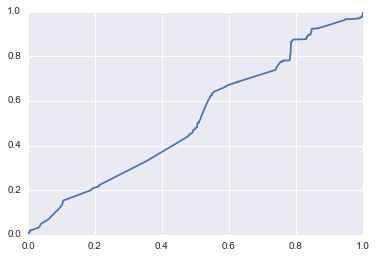

In [1078]:
predictions = lr.predict(X)
probabilities = lr.predict_proba(X)

fpr = metrics.roc_curve(y, probabilities[:,1])[0]
tpr = metrics.roc_curve(y, probabilities[:,1])[1]
plt.plot(fpr, tpr)

print metrics.roc_auc_score(y, lr.predict(X))
print ""
print "can see here performs no better than random selection using AUC scoring"

In [1079]:
# second attempt w/ less features

lr = linear_model.LogisticRegression()

X_reduced_features = autot_valid_bids[['ACTUAL_BID_PRICE','SOFT_FLOOR']]
y = autot_valid_bids.IS_WINNING_BID

lr.fit(X_reduced_features, y)

print lr.score(X_reduced_features, y)

0.707725553755


0.610370304883

using less features get much better AUC score -> 


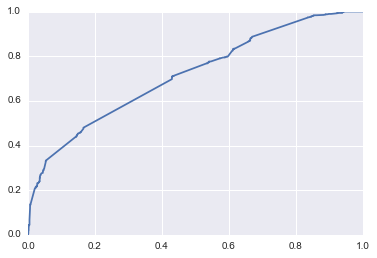

In [1080]:
predictions = lr.predict(X_reduced_features)
probabilities = lr.predict_proba(X_reduced_features)

fpr = metrics.roc_curve(y, probabilities[:,1])[0]
tpr = metrics.roc_curve(y, probabilities[:,1])[1]
plt.plot(fpr, tpr)

print metrics.roc_auc_score(y, lr.predict(X_reduced_features))
print ""
print "using less features get much better AUC score -> "

In [1081]:
# now grid search for best model parameters
ten_fold = cross_validation.KFold(n=len(autot_valid_bids), n_folds=10)

gs = grid_search.GridSearchCV(
    estimator=linear_model.LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-5, 5)],
                'class_weight': [None, 'balanced']},
    cv=ten_fold,
    scoring='roc_auc'
)

gs.fit(X_reduced_features, y)
gs.grid_scores_

[mean: 0.71529, std: 0.04536, params: {'C': 100000, 'class_weight': None},
 mean: 0.71528, std: 0.04537, params: {'C': 100000, 'class_weight': 'balanced'},
 mean: 0.71529, std: 0.04536, params: {'C': 10000, 'class_weight': None},
 mean: 0.71528, std: 0.04537, params: {'C': 10000, 'class_weight': 'balanced'},
 mean: 0.71529, std: 0.04536, params: {'C': 1000, 'class_weight': None},
 mean: 0.71528, std: 0.04537, params: {'C': 1000, 'class_weight': 'balanced'},
 mean: 0.71529, std: 0.04536, params: {'C': 100, 'class_weight': None},
 mean: 0.71528, std: 0.04537, params: {'C': 100, 'class_weight': 'balanced'},
 mean: 0.71529, std: 0.04536, params: {'C': 10, 'class_weight': None},
 mean: 0.71528, std: 0.04537, params: {'C': 10, 'class_weight': 'balanced'},
 mean: 0.71529, std: 0.04536, params: {'C': 1, 'class_weight': None},
 mean: 0.71528, std: 0.04537, params: {'C': 1, 'class_weight': 'balanced'},
 mean: 0.71539, std: 0.04534, params: {'C': 0.1, 'class_weight': None},
 mean: 0.71485, std: 0

In [1082]:
print gs.best_estimator_
print gs.best_score_

LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.717168076318


In [1083]:
# taking best model see how this perfroms
candidate_lr_model = grid_search.GridSearchCV(
    estimator=linear_model.LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-5, 5)],
                'class_weight': [None, 'balanced']},
    cv=ten_fold,
    scoring='roc_auc'
)

candidate_lr_model.fit(X_reduced_features, y)

print "total:", len(y)
print "actual # yes:", sum(y)
print "actual # no:", len(y) - sum(y)
print "predicted # yes:", sum(candidate_lr_model.predict(X_reduced_features))
print "predicted # no:", len(candidate_lr_model.predict(X_reduced_features)) - sum(candidate_lr_model.predict(X_reduced_features))
#print len([ 1 for predicted, actual in zip(lr.predict(X), y) if predicted == actual])
print "tn", len([ 1 for predicted, actual in zip(candidate_lr_model.predict(X_reduced_features), y) if predicted == 0 and actual == 0])
print "tp", len([ 1 for predicted, actual in zip(candidate_lr_model.predict(X_reduced_features), y) if predicted == 1 and actual == 1])
print 

total: 1851
actual # yes: 671
actual # no: 1180
predicted # yes: 517
predicted # no: 1334
tn 985
tp 322



### Candidate Logistic Regression Scoring

In [1084]:
print "CONFUSION MATRIX: (logistic regression)"
print ""
print "       DID BID WIN?"
print "       YES\tNo"
print "P"
print "R YES  {:d}\t{:d} ".format(322, 517-322)
print "E"
print "D No   {:d}\t{:d} ".format(1334-985, 985)

metrics.confusion_matrix(y, candidate_lr_model.predict(X_reduced_features))

CONFUSION MATRIX: (logistic regression)

       DID BID WIN?
       YES	No
P
R YES  322	195 
E
D No   349	985 


array([[985, 195],
       [349, 322]])

In [1085]:
print "acc: ", candidate_lr_model.score(X_reduced_features, y)
lr_with_reduced_features = metrics.precision_score(y, candidate_lr_model.predict(X_reduced_features))
print "tpr: {:f}%".format(322.0 * 100 / (322 + 349))
print "fpr: {:f}%".format(195.0 * 100 / (195 + 985))
print "precision: {:f}%".format(lr_with_reduced_features*100)
print "precision: {:f}%".format(322.0*100/(322+195))

acc:  0.720642097552
tpr: 47.988077%
fpr: 16.525424%
precision: 62.282398%
precision: 62.282398%


### How do Candidate kNN and Logistic Regression models compare?

In [1086]:
# COMPARE! knn v logistic reg

print "logistic regression:"
print "tpr: {:f}%".format(322.0 * 100 / (322 + 349))
print "fpr: {:f}%".format(195.0 * 100 / (195 + 985))
print "precision: {:f}%".format(lr_with_reduced_features*100)
print "precision: {:f}%".format(322.0*100/(322+195))
print "recall: {:f}%".format(322.0*100/(322+349))
print ""
print "KNN:"
print "tpr: {:f}%".format(302.0 * 100 / (302 + 369))
print "fpr: {:f}%".format(54.0 * 100 / (54 + 1126))
print "precision: {:f}%".format(302.0*100/(302+54))
print "recall: {:f}%".format(302.0*100/(302+369))# True Positives / (True Positives + False Negatives)

logistic regression:
tpr: 47.988077%
fpr: 16.525424%
precision: 62.282398%
precision: 62.282398%
recall: 47.988077%

KNN:
tpr: 45.007452%
fpr: 4.576271%
precision: 84.831461%
recall: 45.007452%


In [1087]:
print """
Interpretation: 

    logistic regression - makes more attempts at labelling positives (517),
        therefore has a higher FPR and lower precision.
        
    KNN - has very high precision but makes less positive guesses (312).
"""


Interpretation: 

    logistic regression - makes more attempts at labelling positives (517),
        therefore has a higher FPR and lower precision.
        
    KNN - has very high precision but makes less positive guesses (312).



### Try to Improve Logistic Regression model - transforming ACTUAL_BID_PRICE

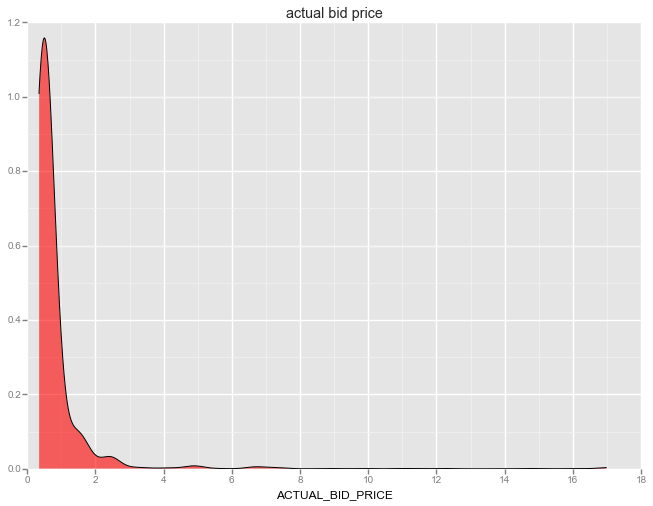

<ggplot: (380264469)>

In [1088]:
ggplot(aes(x='ACTUAL_BID_PRICE'), data=autot_valid_bids) + geom_density(alpha=0.6, colour='black', fill='red') + ggtitle('actual bid price')

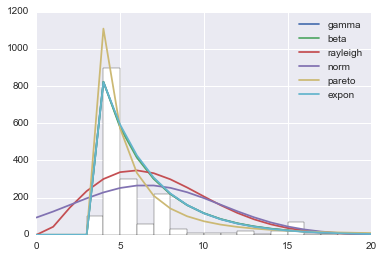

In [1089]:
# look at transformed ACTUAL_BID_PRICE
# first try to find out what distribution our data might resemble
import scipy
import scipy.stats
size = 3000
x = scipy.arange(size)
#y = autot_valid_bids.ACTUAL_BID_PRICE.values * 10
y = rmd_outliers.ACTUAL_BID_PRICE.values * 10
h = plt.hist(y, bins=range(300), color='w')

dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto','expon']

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
    plt.plot(pdf_fitted, label=dist_name)
    plt.xlim(0,20)
plt.legend(loc='upper right')

(3.4568399916980228, 3.0615952082135216)
(12.922703808840554, -47.40962439121023, 2.5905604378609848)
(2.3931418784002982, 2.4506695908470553, -35.859652500316507, 44.768644348150751)
(-39.430537064162927, 1.0)
(-13.932582406151599, 9.2577038084509358)
(615.63485831686125, -13226.413822000599, 13191.007831732859)


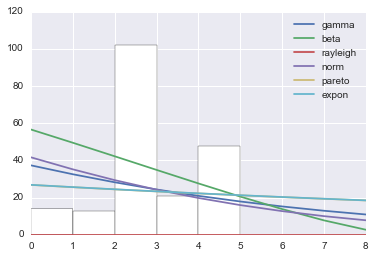

In [1090]:
# Transform rmd_outliers.ACTUAL_BID_PRICE.values
#print scipy.stats.boxcox(rmd_outliers.ACTUAL_BID_PRICE.values * 10)
# NEED TO REFIT DISTRIBUTIONS BETTER TO DATA
size = 3000
x = scipy.arange(size)
#y = autot_valid_bids.ACTUAL_BID_PRICE.values * 10
y = scipy.stats.boxcox(rmd_outliers.ACTUAL_BID_PRICE.values)[0] * 10
h = plt.hist(y, bins=range(500), color='w')

#dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto','expon']

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    print param
    param = dist.fit(y)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
    plt.plot(pdf_fitted, label=dist_name)
    plt.xlim(0,8)
plt.legend(loc='upper right')

In [1091]:
# use this in new logistic reg model w/ reduced features.. X_reduced_features = autot_valid_bids[['ACTUAL_BID_PRICE','SOFT_FLOOR']]

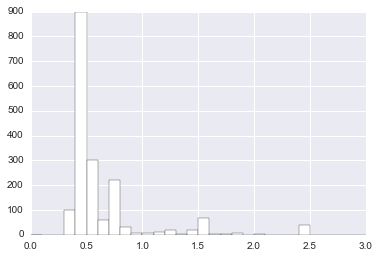

In [1092]:
# look at transformed ACTUAL_BID_PRICE
# first try to find out what distribution our data might resemble
import scipy
import scipy.stats
size = 1400
x = scipy.arange(size)
#y = autot_valid_bids.ACTUAL_BID_PRICE.values * 10
y = rmd_outliers.ACTUAL_BID_PRICE.values# * 10

bin_size = 0.1; min_edge = 0; max_edge = 3
N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, Nplus1)

h = plt.hist(y, bins=bin_list, color='w')

#dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto','expon']

#for dist_name in dist_names:
#    dist = getattr(scipy.stats, dist_name)
#    param = dist.fit(y)
#    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
#    plt.plot(pdf_fitted, label=dist_name)
#    plt.xlim(0,3)
#plt.legend(loc='upper right')

In [1093]:
#dist_names = ['gamma', 'beta', 'rayleigh', 'norm', 'pareto','expon']

#for dist_name in dist_names:
#    dist = getattr(scipy.stats, dist_name)
#    param = dist.fit(y)
#    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
#    plt.plot(pdf_fitted, label=dist_name)
#    plt.xlim(0,3)
#plt.legend(loc='upper right')

y = rmd_outliers.ACTUAL_BID_PRICE.values

param = scipy.stats.expon.fit(y)

bin_size = 0.5; min_edge = 0; max_edge = 8
N = (max_edge-min_edge)/bin_size; Nplus1 = N + 1
bin_list = np.linspace(min_edge, max_edge, N)

pdf_fitted = dist.pdf(bin_list, loc=0, scale=1)

(array([  1.05300000e+03,   5.72000000e+02,   1.27000000e+02,
          1.90000000e+01,   3.90000000e+01,   2.00000000e+00,
          4.00000000e+00,   2.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]),
 array([ 0.        ,  0.53333333,  1.06666667,  1.6       ,  2.13333333,
         2.66666667,  3.2       ,  3.73333333,  4.26666667,  4.8       ,
         5.33333333,  5.86666667,  6.4       ,  6.93333333,  7.46666667,  8.        ]),
 <a list of 15 Patch objects>)

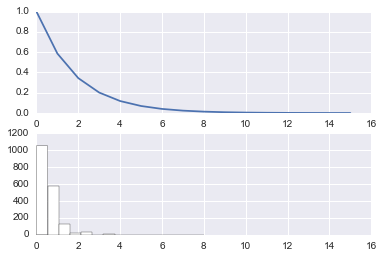

In [1094]:
plt.figure(1)
plt.subplot(211)
plt.plot(pdf_fitted)
plt.subplot(212)
plt.xlim(0,16)
plt.hist(y, bins=bin_list, color='w')

In [1095]:
print bin_list

[ 0.          0.53333333  1.06666667  1.6         2.13333333  2.66666667
  3.2         3.73333333  4.26666667  4.8         5.33333333  5.86666667
  6.4         6.93333333  7.46666667  8.        ]


In [1096]:
# fit model w/ transformed data
lr_trf_model = linear_model.LogisticRegression()

bls_w_trf_act_bid_price = autot_valid_bids.copy()

bls_w_trf_act_bid_price['ACTUAL_BID_PRICE'] = scipy.stats.boxcox(bls_w_trf_act_bid_price['ACTUAL_BID_PRICE'].values)[0]

X_w_trf_act_bid_price = bls_w_trf_act_bid_price[['ACTUAL_BID_PRICE','SOFT_FLOOR']]
y = autot_valid_bids.IS_WINNING_BID

lr_trf_model.fit(X_w_trf_act_bid_price, y)

print lr_trf_model.score(X_w_trf_act_bid_price, y)

# now gridsearch
ten_fold = cross_validation.KFold(n=len(X_w_trf_act_bid_price), n_folds=10)

candidate_lr_trf_model = grid_search.GridSearchCV(
    estimator=linear_model.LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-5, 5)],
                'class_weight': [None, 'balanced']},
    cv=ten_fold,
    scoring='roc_auc'
)

candidate_lr_trf_model = gs.fit(X_w_trf_act_bid_price, y)
candidate_lr_trf_model.grid_scores_
print candidate_lr_trf_model.best_estimator_
print candidate_lr_trf_model.best_score_

0.702323068612
LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
0.699769447153


In [1097]:
print "total:", len(y)
print "actual # yes:", sum(y)
print "actual # no:", len(y) - sum(y)
print "predicted # yes:", sum(candidate_lr_trf_model.predict(X_w_trf_act_bid_price))
print "predicted # no:", len(candidate_lr_trf_model.predict(X_w_trf_act_bid_price)) - sum(candidate_lr_trf_model.predict(X_w_trf_act_bid_price))
print "tn", len([ 1 for predicted, actual in zip(candidate_lr_trf_model.predict(X_w_trf_act_bid_price), y) if predicted == 0 and actual == 0])
print "tp", len([ 1 for predicted, actual in zip(candidate_lr_trf_model.predict(X_w_trf_act_bid_price), y) if predicted == 1 and actual == 1])
print 

total: 1851
actual # yes: 671
actual # no: 1180
predicted # yes: 795
predicted # no: 1056
tn 785
tp 400



### Scoring Candidate Logistic Regression w/ transformed ACTUAL_BID_PRICE

In [1098]:
print "CONFUSION MATRIX: (logistic regression w/ transformed actual bid prices)"
print ""
print "       DID BID WIN?"
print "       YES\tNo"
print "P"
print "R YES  {:d}\t{:d} ".format(400, 795-400)
print "E"
print "D No   {:d}\t{:d} ".format(1056-785, 785)

metrics.confusion_matrix(y, candidate_lr_trf_model.predict(X_w_trf_act_bid_price))

CONFUSION MATRIX: (logistic regression w/ transformed actual bid prices)

       DID BID WIN?
       YES	No
P
R YES  400	395 
E
D No   271	785 


array([[785, 395],
       [271, 400]])

In [ ]:
print "Logistic Regression w/  tramsformed data:"
print "tpr: {:f}%".format(400.0 * 100 / (400 + 271))
print "fpr: {:f}%".format(395.0 * 100 / (395 + 785))
print "precision: {:f}%".format(400.0*100/(400+395))# True Positives / (True Positives + False Negatives)
print "acc: ", candidate_lr_trf_model.score(X_w_trf_act_bid_price,y)

Logistic Regression w/  tramsformed data:
tpr: 59.612519%
fpr: 33.474576%
precision: 50.314465%
acc:  0.703407512188


### Ensemble, Voting Classifier

In [ ]:
# try ensemble classifier

# candidate_lr_model
clf1 = grid_search.GridSearchCV(
    estimator=linear_model.LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-5, 5)],
                'class_weight': [None, 'balanced']},
    cv=ten_fold,
    scoring='roc_auc'
)

# candidate_lr_trf_model
clf2 = grid_search.GridSearchCV(
    estimator=linear_model.LogisticRegression(),
    param_grid={'C': [10**-i for i in range(-5, 5)],
                'class_weight': [None, 'balanced']},
    cv=ten_fold,
    scoring='roc_auc'
)

# candidate_model_knn
clf3 = grid_search.GridSearchCV(
    estimator=neighbors.KNeighborsClassifier(),
    param_grid={
        'n_neighbors': try_neighbours,
        'weights': ['distance']
    },
    cv=kf)

X_reduced_features = autot_valid_bids[['ACTUAL_BID_PRICE','SOFT_FLOOR']]
y = autot_valid_bids.IS_WINNING_BID

eclf1 = ensemble.VotingClassifier(
            estimators=[('knn', clf1), ('lr', clf2), ('lrtrf', clf3)],
            voting='hard')

eclf1 = eclf1.fit(X_reduced_features, y)
#print(eclf1.predict(X_reduced_features))
print eclf1.score(X_reduced_features, y)

eclf2 = ensemble.VotingClassifier(
            estimators=[('knn', clf1), ('lr', clf2), ('lrtrf', clf3)],
            voting='soft')

eclf2 = eclf2.fit(X_reduced_features, y)
#print(eclf2.predict(X_reduced_features))
print eclf2.score(X_reduced_features, y)


eclf3 = ensemble.VotingClassifier(
            estimators=[('knn', clf1), ('lr', clf2), ('lrtrf', clf3)],
            voting='soft', weights=[2,2,1])

eclf3 = eclf3.fit(X_reduced_features, y)
#print(eclf3.predict(X_reduced_features))
print eclf3.score(X_reduced_features, y)

0.706104808212
0.768233387358


In [ ]:
eclf3 = ensemble.VotingClassifier(
            estimators=[('knn', clf1), ('lr', clf2), ('lrtrf', clf3)],
            voting='soft', weights=[1,1,2])

eclf3 = eclf3.fit(X_reduced_features, y)
#print(eclf3.predict(X_reduced_features))
print eclf3.score(X_reduced_features, y)

In [ ]:
print "total:", len(y)
print "actual # yes:", sum(y)
print "actual # no:", len(y) - sum(y)
print "predicted # yes:", sum(eclf3.predict(X_reduced_features))
print "predicted # no:", len(eclf3.predict(X_reduced_features)) - sum(eclf3.predict(X_reduced_features))
print "tn", len([ 1 for predicted, actual in zip(eclf3.predict(X_reduced_features), y) if predicted == 0 and actual == 0])
print "tp", len([ 1 for predicted, actual in zip(eclf3.predict(X_reduced_features), y) if predicted == 1 and actual == 1])
print 

In [ ]:
print "CONFUSION MATRIX: (ensemble)"
print ""
print "       DID BID WIN?"
print "       YES\tNo"
print "P"
print "R YES  {:d}\t{:d} ".format(309, 370-309)
print "E"
print "D No   {:d}\t{:d} ".format(1481-1119, 1119)

metrics.confusion_matrix(y, eclf3.predict(X_reduced_features))

In [ ]:
print "Ensemble: "
print "tpr: {:f}%".format(309.0 * 100 / (309 + 362))
print "fpr: {:f}%".format(61.0 * 100 / (61 + 1119))
print "precision: {:f}%".format(309.0*100/(309+61))
print "recall: {:f}%".format(309.0*100/(309+362))# True Positives / (True Positives + False Negatives)

### Testing Models for generalisation

In [ ]:
# test models for generalisation

#bls_05_01_12.head()
#std_05_01_12.head()

In [ ]:
print std_05_01_12[[0,31]].iloc[0:3]
print ""
print std_05_01_12[std_05_01_12[31] == 'autotrader.co.uk'][[0,31]].iloc[0:3]
print ""
print "std feed autotrader auction row count: ", len(std_05_01_12[std_05_01_12[31] == 'autotrader.co.uk'])

In [ ]:
test_set_autotrader_auction_ids = [ id for id in std_05_01_12[std_05_01_12[31] == 'autotrader.co.uk'][0]]
# check ok
print len(test_set_autotrader_auction_ids)
print ""
print test_set_autotrader_auction_ids[5]
print ""
print std_05_01_12[std_05_01_12[0] == test_set_autotrader_auction_ids[5]][31]

In [ ]:
autotrader_bls_05_01_12 = bls_05_01_12[bls_05_01_12['AUCTION_ID_64'].isin(test_set_autotrader_auction_ids)]
print "bls feed row count: ", len(bls_05_01_12)
print "(autotrader auctions only) bls feed row count: ", len(autotrader_bls_05_01_12)
print "prior probability/bias (all bls bids winning bid %): {:f}%".format(bls_05_01_12['IS_WINNING_BID'].mean() * 100)
print "prior probability/bias (autotrader bids winning bid %): {:f}%".format(autotrader_bls_05_01_12['IS_WINNING_BID'].mean() * 100)

In [ ]:
test_set_autot_valid_bids = autotrader_bls_05_01_12[autotrader_bls_05_01_12['BID_REJECT_REASON'] == 0]
test_set_autot_valid_bids['BID_REJECT_REASON'].head()

In [ ]:
# test generalisation of kNN

test_set_input_X = test_set_autot_valid_bids[['ACTUAL_BID_PRICE', 'SOFT_FLOOR']]
test_set_outcome_y = test_set_autot_valid_bids['IS_WINNING_BID']

In [ ]:
#### print "HOW DOES KNN MODEL GENERALISE?"
print ""
print "total:", len(test_set_outcome_y)
print "actual # yes:", sum(test_set_outcome_y)
print "actual # no:", len(test_set_outcome_y) - sum(test_set_outcome_y)
print "predicted # yes:", sum(candidate_model_knn.predict(test_set_input_X))
print "predicted # no:", len(candidate_model_knn.predict(test_set_input_X)) - sum(candidate_model_knn.predict(test_set_input_X))

print "tn", len([ 1 for predicted, actual in zip(candidate_model_knn.predict(test_set_input_X), test_set_outcome_y) if predicted == 0 and actual == 0])
print "tp", len([ 1 for predicted, actual in zip(candidate_model_knn.predict(test_set_input_X), test_set_outcome_y) if predicted == 1 and actual == 1])
print 

print "CONFUSION MATRIX:"
print ""
print "       DID BID WIN?"
print "       YES\tNo"
print "P"
print "R YES  {:d}\t{:d} ".format(139, 184-139)
print "E"
print "D No   {:d}\t{:d} ".format(320-174, 174)

print metrics.confusion_matrix(test_set_outcome_y, candidate_model_knn.predict(test_set_input_X))

print ""
print "tpr: {:f}%".format(139.0 * 100 / (139 + 146))
print "fpr: {:f}%".format(45.0 * 100 / (45 + 174))
print "precision: {:f}%".format(139.0*100/(139+45))
print "recall: {:f}%".format(139.0*100/(139+146))
print "acc: {:f}%".format(candidate_model_knn.score(test_set_input_X, test_set_outcome_y))

In [ ]:
print "HOW DOES LR MODEL GENERALISE?"
print ""
print "total:", len(test_set_outcome_y)
print "actual # yes:", sum(test_set_outcome_y)
print "actual # no:", len(test_set_outcome_y) - sum(test_set_outcome_y)
print "predicted # yes:", sum(candidate_lr_model.predict(test_set_input_X))
print "predicted # no:", len(candidate_lr_model.predict(test_set_input_X)) - sum(candidate_lr_model.predict(test_set_input_X))

print "tn", len([ 1 for predicted, actual in zip(candidate_lr_model.predict(test_set_input_X), test_set_outcome_y) if predicted == 0 and actual == 0])
print "tp", len([ 1 for predicted, actual in zip(candidate_lr_model.predict(test_set_input_X), test_set_outcome_y) if predicted == 1 and actual == 1])
print 

print "CONFUSION MATRIX: (logistic regression)"
print ""
print "       DID BID WIN?"
print "       YES\tNo"
print "P"
print "R YES  {:d}\t{:d} ".format(187, 57)
print "E"
print "D No   {:d}\t{:d} ".format(98, 162)

print metrics.confusion_matrix(test_set_outcome_y, candidate_lr_model.predict(test_set_input_X))

print "Logistic Regression:"
print "tpr: {:f}%".format(187.0 * 100 / (187 + 98))
print "fpr: {:f}%".format(57.0 * 100 / (57 + 162))
print "precision: {:f}%".format(187.0*100/(187+57))
print "recall: {:f}%".format(187.0*100/(187+98))
print "acc: {:f}%".format(candidate_lr_model.score(test_set_input_X,test_set_outcome_y))

In [ ]:
print "HOW DOES LR (w/ transformed bids) MODEL GENERALISE?"
print ""
print "total:", len(test_set_outcome_y)
print "actual # yes:", sum(test_set_outcome_y)
print "actual # no:", len(test_set_outcome_y) - sum(test_set_outcome_y)
print "predicted # yes:", sum(candidate_lr_trf_model.predict(test_set_input_X))
print "predicted # no:", len(candidate_lr_trf_model.predict(test_set_input_X)) - sum(candidate_lr_trf_model.predict(test_set_input_X))

print "tn", len([ 1 for predicted, actual in zip(candidate_lr_trf_model.predict(test_set_input_X), test_set_outcome_y) if predicted == 0 and actual == 0])
print "tp", len([ 1 for predicted, actual in zip(candidate_lr_trf_model.predict(test_set_input_X), test_set_outcome_y) if predicted == 1 and actual == 1])
print 

print "CONFUSION MATRIX: (logistic regression w/ transformed actual bid prices)"
print ""
print "       DID BID WIN?"
print "       YES\tNo"
print "P"
print "R YES  {:d}\t{:d} ".format(285, 219)
print "E"
print "D No   {:d}\t{:d} ".format(0, 0)

print metrics.confusion_matrix(test_set_outcome_y, candidate_lr_trf_model.predict(test_set_input_X))

print "Logistic Regression w/  tramsformed data:"
print "tpr: {:f}%".format(285.0 * 100 / (285 + 0))
print "fpr: {:f}%".format(219.0 * 100 / (219 + 0))
print "precision: {:f}%".format(285.0*100/(285+219))
print "recall: {:f}%".format(285.0 * 100 / (285 + 0))
print "acc: {:f}%".format(candidate_lr_trf_model.score(test_set_input_X,test_set_outcome_y))

In [1042]:
print "HOW DOES Ensemble (w/ voting) MODEL GENERALISE?"
print ""
print "total:", len(test_set_outcome_y)
print "actual # yes:", sum(test_set_outcome_y)
print "actual # no:", len(test_set_outcome_y) - sum(test_set_outcome_y)
print "predicted # yes:", sum(eclf3.predict(test_set_input_X))
print "predicted # no:", len(eclf3.predict(test_set_input_X)) - sum(eclf3.predict(test_set_input_X))

print "tn", len([ 1 for predicted, actual in zip(eclf3.predict(test_set_input_X), test_set_outcome_y) if predicted == 0 and actual == 0])
print "tp", len([ 1 for predicted, actual in zip(eclf3.predict(test_set_input_X), test_set_outcome_y) if predicted == 1 and actual == 1])
print 

print "CONFUSION MATRIX: (Ensemble w/ voting)"
print ""
print "       DID BID WIN?"
print "       YES\tNo"
print "P"
print "R YES  {:d}\t{:d} ".format(141, 33)
print "E"
print "D No   {:d}\t{:d} ".format(144, 186)

print metrics.confusion_matrix(test_set_outcome_y, eclf3.predict(test_set_input_X))

print "Ensemble (w/ voting)"
print "tpr: {:f}%".format(141.0 * 100 / (141 + 144))
print "fpr: {:f}%".format(33.0 * 100 / (33 + 186))
print "precision: {:f}%".format(141.0*100/(141+33))
print "recall: {:f}%".format(141.0 * 100 / (141 + 144))
print "acc: {:f}%".format(eclf3.score(test_set_input_X,test_set_outcome_y)*100)

HOW DOES Ensemble (w/ voting) MODEL GENERALISE?

total: 504
actual # yes: 285
actual # no: 219
predicted # yes: 174
predicted # no: 330
tn 186
tp 141

CONFUSION MATRIX: (Ensemble w/ voting)

       DID BID WIN?
       YES	No
P
R YES  141	33 
E
D No   144	186 
[[186  33]
 [144 141]]
Logistic Regression w/  tramsformed data:
tpr: 49.473684%
fpr: 15.068493%
precision: 81.034483%
recall: 49.473684%
acc: 0.648810%


## Conclusion & Findings

Based on both the scoring on the modelling dataset (24/04/2016) and scoring on the "unseen" dataset (01/05/2016) the untransformed Logistic Regression model seems to be the best that I have found but there seems to be little difference between this and the kNN model.

#### 24/04/2016
K Nearest Neighbours (grid-searched, 5 fold cross validation, weights: distance)
Accuracy: 77.15%, TPR/Recall: 45.01%, FPR: 4.58%, Precision: 84.83% 

Logistic Regression (grid-searched, 10 fold cross validation, ROC scoring)
Accuracy: 72.06%, TPR/Recall: 47.99%, FPR: 16.52%, Precision: 62.28%

Logistic Regression w/ transformed data (grid-searched, 10 fold cross validation, ROC scoring)
Accuracy: 70.34%, TPR/Recall: 59.61%, FPR: 33.47%, Precision: 50.31%

Ensemble of above w/ Voting (3 above grid-searched classifiers votes weighted 1,1,2 respectively)
Accuracy: 77.15%, TPR/Recall: 46.05%, FPR: 5.17%, Precision: 83.51%

#### 01/05/2016
K Nearest Neighbours (grid-searched, 5 fold cross validation, weights: distance)
Accuracy: 75.69%, TPR/Recall: 48.77%, FPR: 20.55%, Precision: 75.54%

Logistic Regression (grid-searched, 10 fold cross validation, ROC scoring)
Accuracy: 72.06%, TPR/Recall: 65.61%, FPR: 26.03%, Precision: 76.64%

Logistic Regression w/ transformed data (grid-searched, 10 fold cross validation, ROC scoring)
Accuracy: 76.01%, TPR/Recall: 100.00%, FPR: 100.00%, Precision: 56.55%

Ensemble of above w/ Voting (3 above grid-searched classifiers votes weighted 1,1,2 respectively)
Accuracy: 64.88%, TPR/Recall: 49.47%, FPR: 15.07%, Precision: 81.03%

From above it is clear that Logistic Regression w/ transformed data generalises poorly and is the worst model even on the data the models are built on. Both Logistic regression do well on both datasets. the Ensemble generalises slightly less well than these two due to using the logistic regression w/ transformed data as one of the voters. If it is desired to make more attempts at predicting all winning bids Logistic regression would be the better model, but if we were just looking at accuracy kNN would be the right model to choose.

The only features used in this model were WINNING_BID_PRICE and SOFT_FLOOR which is in contradiction to my hypothesised outcome that features like brand_id and buyer_id would be important in predicting winning bids.

To improve my analysis and build better models I would also like to bring in more features from the "Standard Feed" dataset such as ad unit size (build new feature from width and height columns) and fold_position. This could help imporve my chosen Logistic regression model, but may not help or could even worsen performance of a kNN classifier due to the "Curse of Dimensionality". 

I would also like to use Principle Components Analysis to investigate further in to the importance of all possible features on explaining the variance in my data.

Finally I would like to extend my modelling and testing to look at other days and Ideally use Time Series Analysis to look in to seasonality and cyclicality in bidding patterns as We know there are trends where for exmaple agencies need to spend their budgets at the end of each month and so may begin to bid higher in these situations. 